# Домашняя работа №10

Будем решать задачу сентимент-анализа. В архиве data/sentiment analisys.zip лежит несколько эксель файлов с твитами разных пользователей на разных языках (один файл - один язык).

Нужно выбрать один из файлов и провести над ним работу.


Easy Оценить сбалансированность классов.

Удалить пунктуацию из датасета.

Преобразовать датасет в BOW или TF-IDF, поделить на треин-тест и спрогнозировать вашей любимой моделью

In [1]:
# импортируем сразу все, что может понадобиться
import numpy as np
import pandas as pd
import re
import pymorphy2
import matplotlib.pyplot as plt
from nltk.stem.porter import *
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, precision_score
from sklearn.tree import DecisionTreeClassifier
import nltk 
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('data/sentiment analysis/Ferguson sentiment CODED.xlsx')   # выбрали файл

In [3]:
df  # смотрим, что представляет из себя

,user,tweet,sentiment,"1 - positive, 2 - negative, 3 - neutral",Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,disetv,#stl we war ready #ripmikebrown #ferguson http...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,deray,one of the best moments from ystrdy was when a...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,deray,public art. canfield. photo. #ferguson http://...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,deray,canfield. public art cont. #ferguson http://if...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,deray,public art exhibit. canfield. #ferguson http:/...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,wuperkins,#ferguson black man telling story of mopping c...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202,wuperkins,@ryanjreilly very good. now if @govjaynixon wo...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1203,wuperkins,@chucktodd hopefully folks r traveling to #fer...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1204,wuperkins,@wesleylowery hold govt. accountable. #nojusti...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df[['user','tweet','sentiment']].dropna() # формируем базовый датафрейм с необходимыми данными, применяем dropna, убираем пустые столбцы с NaN

In [5]:
df

,user,tweet,sentiment
0,disetv,#stl we war ready #ripmikebrown #ferguson http...,2
1,deray,one of the best moments from ystrdy was when a...,2
2,deray,public art. canfield. photo. #ferguson http://...,3
3,deray,canfield. public art cont. #ferguson http://if...,3
4,deray,public art exhibit. canfield. #ferguson http:/...,3
...,...,...,...
1200,wuperkins,all the injustices/mayhem out of #ferguson fin...,3
1201,wuperkins,#ferguson black man telling story of mopping c...,2
1202,wuperkins,@ryanjreilly very good. now if @govjaynixon wo...,3
1203,wuperkins,@chucktodd hopefully folks r traveling to #fer...,3


In [6]:
df.loc[df['sentiment']==1, 'P_N_N'] = '"+"' # наглядно отобразим какие отзывы какими являются

In [7]:
df.loc[df['sentiment']==2, 'P_N_N'] = 'neutral'

In [8]:
df.loc[df['sentiment']==3, 'P_N_N'] = '""-""'

In [9]:
df.head()

,user,tweet,sentiment,P_N_N
0,disetv,#stl we war ready #ripmikebrown #ferguson http...,2,neutral
1,deray,one of the best moments from ystrdy was when a...,2,neutral
2,deray,public art. canfield. photo. #ferguson http://...,3,"""""-"""""
3,deray,canfield. public art cont. #ferguson http://if...,3,"""""-"""""
4,deray,public art exhibit. canfield. #ferguson http:/...,3,"""""-"""""


In [10]:
# оцениваем сбалансированность классов, построим гистограмму

<AxesSubplot:>

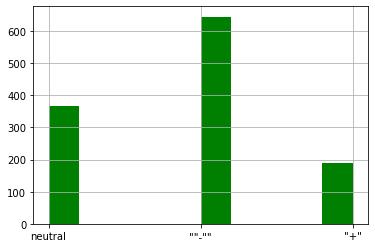

In [11]:
df.P_N_N.hist(bins=10, color = 'green', label = ['Сбалансированность']) 

Вывод: классы не сбалансированы (позитивных + мало, негативных - много, нейтральных в меру)

In [12]:
len(df)

1203

In [13]:
# Удалим пунктуацию и поместим с столбец tweet_z

In [14]:
for i in range(len(df)):
    i1 = str(df.iloc[i,1])
    i2 = re.sub(r'[^\w\s]','', i1)
    df.loc[df.index==(i), 'tweet_z'] = i2

In [15]:
df.head()  # смотрим, что получилось:

,user,tweet,sentiment,P_N_N,tweet_z
0,disetv,#stl we war ready #ripmikebrown #ferguson http...,2,neutral,stl we war ready ripmikebrown ferguson httpins...
1,deray,one of the best moments from ystrdy was when a...,2,neutral,one of the best moments from ystrdy was when a...
2,deray,public art. canfield. photo. #ferguson http://...,3,"""""-""""",public art canfield photo ferguson httpiftttw1...
3,deray,canfield. public art cont. #ferguson http://if...,3,"""""-""""",canfield public art cont ferguson httpifttt1ld...
4,deray,public art exhibit. canfield. #ferguson http:/...,3,"""""-""""",public art exhibit canfield ferguson httpifttt...


In [16]:
# Займемся преобразованием датасета в tf-idf

In [17]:
tf_idf = TfidfVectorizer()

In [18]:
df['P_N_N'] = pd.Categorical(df.P_N_N)

In [19]:
df['coded'] = df.P_N_N.cat.codes

In [20]:
df.head()

,user,tweet,sentiment,P_N_N,tweet_z,coded
0,disetv,#stl we war ready #ripmikebrown #ferguson http...,2,neutral,stl we war ready ripmikebrown ferguson httpins...,2
1,deray,one of the best moments from ystrdy was when a...,2,neutral,one of the best moments from ystrdy was when a...,2
2,deray,public art. canfield. photo. #ferguson http://...,3,"""""-""""",public art canfield photo ferguson httpiftttw1...,0
3,deray,canfield. public art cont. #ferguson http://if...,3,"""""-""""",canfield public art cont ferguson httpifttt1ld...,0
4,deray,public art exhibit. canfield. #ferguson http:/...,3,"""""-""""",public art exhibit canfield ferguson httpifttt...,0


In [21]:
x = tf_idf.fit_transform(df.tweet)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, df.coded, train_size=0.6)  # разбиваем train - test

Применим разные модели:

In [23]:
model = SGDClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
as1 = accuracy_score(y_pred, y_test)

In [24]:
print('accuracy_score по модели SGDClassifier составил', as1)

accuracy_score по модели SGDClassifier составил 0.6618257261410788


In [25]:
confusion_matrix(y_test, y_pred)

array([[216,   7,  40],
       [ 35,  30,   6],
       [ 69,   6,  73]], dtype=int64)

In [26]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
as2 = accuracy_score(y_pred, y_test)

In [27]:
print('accuracy_score по модели DecisionTreeClassifier составил', as2)

accuracy_score по модели DecisionTreeClassifier составил 0.5352697095435685


In [28]:
confusion_matrix(y_test, y_pred)

array([[186,  20,  57],
       [ 41,  12,  18],
       [ 71,  17,  60]], dtype=int64)

In [29]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
as3 = accuracy_score(y_pred, y_test)

In [30]:
print('accuracy_score по модели RandomForestClassifier составил', as3)

accuracy_score по модели RandomForestClassifier составил 0.6099585062240664


In [31]:
confusion_matrix(y_test, y_pred)

array([[248,   0,  15],
       [ 58,   6,   7],
       [108,   0,  40]], dtype=int64)

In [32]:
maximum_quality = max(as1, as2, as3)

In [33]:
print('По accuracy_score при сравнении моделей между собой:')
if maximum_quality == as1:
    print('Наилучшее качество у модели SGDClassifier, в %ах составляет:', as1*100)
elif maximum_quality == as2:
    print('Наилучшее качество у модели DecisionTreeClassifier, в %ах составляет:', as2*100)
else:
    print('Наилучшее качество у модели RandomForestClassifier, в %ах составляет:', as3*100)

По accuracy_score при сравнении моделей между собой:
Наилучшее качество у модели SGDClassifier, в %ах составляет: 66.18257261410788


При этом качество все равно является достаточно невысоким

NORMAL

Normal
Удалить стоп-слова из датасета, использовать стеммер Портера (лежит в src/porter.py). Использовать пайплайн для TF-IDF и модели машинного обучения. Подобрать параметры. Сравнить качество нескольких моделей.


In [34]:
ST = PorterStemmer()  # используем стеммер Портера - у нас англ. яз. в датасете

In [35]:
for i in range(len(df)):
    b1 = str(df.iloc[i,4])
    b2 = ST.stem(b1)
    df.loc[df.index==(i), 'tweet_2'] = b2

In [36]:
df.head()

,user,tweet,sentiment,P_N_N,tweet_z,coded,tweet_2
0,disetv,#stl we war ready #ripmikebrown #ferguson http...,2,neutral,stl we war ready ripmikebrown ferguson httpins...,2,stl we war ready ripmikebrown ferguson httpins...
1,deray,one of the best moments from ystrdy was when a...,2,neutral,one of the best moments from ystrdy was when a...,2,one of the best moments from ystrdy was when a...
2,deray,public art. canfield. photo. #ferguson http://...,3,"""""-""""",public art canfield photo ferguson httpiftttw1...,0,public art canfield photo ferguson httpiftttw1...
3,deray,canfield. public art cont. #ferguson http://if...,3,"""""-""""",canfield public art cont ferguson httpifttt1ld...,0,canfield public art cont ferguson httpifttt1ld...
4,deray,public art exhibit. canfield. #ferguson http:/...,3,"""""-""""",public art exhibit canfield ferguson httpifttt...,0,public art exhibit canfield ferguson httpifttt...


In [37]:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", LogisticRegression()),
    ]
)

In [38]:
df = df.dropna()

In [39]:
df.head(10)

,user,tweet,sentiment,P_N_N,tweet_z,coded,tweet_2
0,disetv,#stl we war ready #ripmikebrown #ferguson http...,2,neutral,stl we war ready ripmikebrown ferguson httpins...,2,stl we war ready ripmikebrown ferguson httpins...
1,deray,one of the best moments from ystrdy was when a...,2,neutral,one of the best moments from ystrdy was when a...,2,one of the best moments from ystrdy was when a...
2,deray,public art. canfield. photo. #ferguson http://...,3,"""""-""""",public art canfield photo ferguson httpiftttw1...,0,public art canfield photo ferguson httpiftttw1...
3,deray,canfield. public art cont. #ferguson http://if...,3,"""""-""""",canfield public art cont ferguson httpifttt1ld...,0,canfield public art cont ferguson httpifttt1ld...
4,deray,public art exhibit. canfield. #ferguson http:/...,3,"""""-""""",public art exhibit canfield ferguson httpifttt...,0,public art exhibit canfield ferguson httpifttt...
5,deray,&quot;we have nothing to lose but our chains.&...,2,neutral,quotwe have nothing to lose but our chainsquot...,2,quotwe have nothing to lose but our chainsquot...
6,deray,"now, we transition to the role of intersection...",3,"""""-""""",now we transition to the role of intersectiona...,0,now we transition to the role of intersectiona...
7,deray,fellowship. #blacklivesmatter #ferguson http:/...,3,"""""-""""",fellowship blacklivesmatter ferguson httpifttt...,0,fellowship blacklivesmatter ferguson httpifttt...
8,deray,"by far, the best benediction i&#39;ve ever exp...",1,"""+""",by far the best benediction i39ve ever experie...,1,by far the best benediction i39ve ever experie...
9,deray,comparison between the occupied territory jesu...,1,"""+""",comparison between the occupied territory jesu...,1,comparison between the occupied territory jesu...


In [40]:
x = df.tweet_2
y = df.coded
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6)

In [41]:
pp1 = pipeline.fit(x_train, y_train)
pp1

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())])

In [42]:
y_pred = pipeline.predict(df['tweet_2'])
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [43]:
asc1 = accuracy_score(y, y_pred)
asc1

0.7468776019983348

In [44]:
confusion_matrix(y, y_pred)

array([[607,   3,  33],
       [142,  32,  16],
       [110,   0, 258]], dtype=int64)

In [45]:
print ('для пайплайна:')
print('accuracy_score составляет:', accuracy_score(y, y_pred)*100,'%')

для пайплайна:
accuracy_score составляет: 74.68776019983348 %


In [46]:
# Осуществим подбор параметров:

In [47]:
params = {
    'vect__max_features': [3, 4, 6],
    'tfidf__norm': ['l1', 'l2'],
    'tfidf__sublinear_tf': ['True', 'False'],
    'clf__max_iter': [30, 60, 90]
}

In [48]:
search = RandomizedSearchCV(pipeline, params)
search.fit(x_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('clf', LogisticRegression())]),
                   param_distributions={'clf__max_iter': [30, 60, 90],
                                        'tfidf__norm': ['l1', 'l2'],
                                        'tfidf__sublinear_tf': ['True',
                                                                'False'],
                                        'vect__max_features': [3, 4, 6]})

In [49]:
search.best_estimator_  # Лучшие параметры

Pipeline(steps=[('vect', CountVectorizer(max_features=3)),
                ('tfidf', TfidfTransformer(norm='l1', sublinear_tf='False')),
                ('clf', LogisticRegression(max_iter=60))])

In [50]:
# внесем в пайплайн:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer(max_features=4)),
        ("tfidf", TfidfTransformer(norm='l1', sublinear_tf='False')),
        ("clf", LogisticRegression(max_iter=30)),
    ]
)

In [51]:
pp2 = pipeline.fit(x_train, y_train)
pp2

Pipeline(steps=[('vect', CountVectorizer(max_features=4)),
                ('tfidf', TfidfTransformer(norm='l1', sublinear_tf='False')),
                ('clf', LogisticRegression(max_iter=30))])

In [52]:
y_pred = pipeline.predict(df['tweet_2'])
y_pred

array([0, 0, 0, ..., 0, 2, 2], dtype=int8)

In [53]:
asc2 = accuracy_score(y, y_pred)
asc2

0.5353871773522065

In [54]:
confusion_matrix(y, y_pred)

array([[616,   0,  27],
       [188,   0,   2],
       [341,   0,  27]], dtype=int64)

In [55]:
print ('для пайплайна после подбора параметров:')
print('accuracy_score составляет:', accuracy_score(y, y_pred)*100,'%')
if asc2 < asc1:
    print('Качество ухудшилось')
else:
    print('Качество улучшилось')


для пайплайна после подбора параметров:
accuracy_score составляет: 53.53871773522065 %
Качество ухудшилось


In [56]:
# Другой пайплайн - например, с DecisionTreeClassifier
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", DecisionTreeClassifier()),
    ]
)

In [57]:
pp3 = pipeline.fit(x_train, y_train)
pp3

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier())])

In [58]:
y_pred = pipeline.predict(df['tweet_2'])
y_pred

array([2, 1, 0, ..., 0, 0, 0], dtype=int8)

In [59]:
asc3 = accuracy_score(y, y_pred)
asc3

0.794338051623647

In [60]:
confusion_matrix(y, y_pred)

array([[547,  46,  50],
       [ 47, 129,  14],
       [ 64,  26, 278]], dtype=int64)

In [61]:
min_score = min(asc1, asc2, asc3)

In [62]:
print ('для пайплайна с DecisionTreeClassifier:')
print('accuracy_score составляет:', asc3*100,'%')

для пайплайна с DecisionTreeClassifier:
accuracy_score составляет: 79.4338051623647 %


In [63]:
print('Вывод:')
print('Из рассмотренных моделей:')
if min_score == asc3:
    print('Наихудшее качество по accuracy_score у пайплайна с DecisionTreeClassifier как clf')
elif min_score == asc1:
    print('Наихудшее качество по accuracy_score у пайплайна с LogisticRegression как clf до подбора параметров')
else:
    print('Наихудшее качество по accuracy_score у пайплайна с DecisionTreeClassifier как clf с подбором параметров')

Вывод:
Из рассмотренных моделей:
Наихудшее качество по accuracy_score у пайплайна с DecisionTreeClassifier как clf с подбором параметров
